# CySkin Data Exploration & Visualization

This notebook explores the tactile sensor data collected from the CySkin system.
We'll analyze raw signals, spatial patterns, and gesture differences before ML analysis.

In [13]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [14]:
# Load and parse data
def load_sample(file_path):
    """Load a single sample file and return sensor IDs, timestamps, and sensor data"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Parse header (sensor IDs)
    sensor_ids = list(map(int, lines[0].strip().split()))
    
    # Parse timesteps
    timesteps = []
    timestamps = []
    sensor_data = []
    
    for line in lines[1:]:
        values = list(map(float, line.strip().split()))
        timesteps.append(int(values[0]))
        timestamps.append(values[1])
        sensor_data.append(values[2:])
    
    return {
        'sensor_ids': sensor_ids,
        'timesteps': timesteps,
        'timestamps': timestamps,
        'data': np.array(sensor_data)  # Shape: (timesteps, sensors)
    }



In [15]:
# Find all sample files
data_dir = Path("/home/lidia/ros2_ws/src/cyskin_acquisition/data")
sample_files = sorted(glob.glob(str(data_dir / "*" / "sample_*.txt")))

print(f"Found {len(sample_files)} sample files")

# Show unique gesture folders
if sample_files:
    unique_gestures = sorted(set(Path(f).parent.name for f in sample_files))
    print(f"Gesture folders: {unique_gestures}")
    
    # Show sample count per gesture
    gesture_counts = {} # Empty dictionary to hold counts
    for f in sample_files:
        gesture = Path(f).parent.name
        gesture_counts[gesture] = gesture_counts.get(gesture, 0) + 1
    
    print("Sample count per gesture:")
    for gesture in sorted(gesture_counts.keys()):
        print(f"  • {gesture}: {gesture_counts[gesture]} samples")
else:
    print(" No sample files found!")
    print(f"Checking if data directory exists: {data_dir.exists()}")
    if data_dir.exists():
        subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
        print(f"Found subdirectories: {[d.name for d in subdirs]}")

Found 373 sample files
Gesture folders: ['0_finger', '1_finger', '2_finger', '3_finger', '4_finger', '5_finger']
Sample count per gesture:
  • 0_finger: 41 samples
  • 1_finger: 51 samples
  • 2_finger: 70 samples
  • 3_finger: 70 samples
  • 4_finger: 70 samples
  • 5_finger: 71 samples


In [16]:
# Basic dataset overview
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)

# Load first sample to check dimensions
if sample_files:
    first_sample = load_sample(sample_files[0])
    
    print(f" Sample Structure:")
    print(f"   • Number of sensors: {len(first_sample['sensor_ids'])}")
    print(f"   • Timesteps per sample: {len(first_sample['timesteps'])}")
    print(f"   • Duration: {first_sample['timestamps'][-1]:.2f} seconds")
    print(f"   • Sampling rate: ~{len(first_sample['timesteps'])/first_sample['timestamps'][-1]:.1f} Hz")
    
    # Count samples per gesture
    gesture_counts = {}
    for f in sample_files:
        gesture = Path(f).parent.name
        gesture_counts[gesture] = gesture_counts.get(gesture, 0) + 1
    
    print(f"\n Samples per gesture:")
    total_samples = 0
    for gesture, count in sorted(gesture_counts.items()):
        print(f"   • {gesture}: {count} samples")
        total_samples += count
    
    print(f"\n Total dataset: {total_samples} samples")
    print(f" Feature vector size: {len(first_sample['timesteps']) * len(first_sample['sensor_ids'])}")
    
else:
    print(" No sample files found! Check the data directory path.")

DATASET OVERVIEW
 Sample Structure:
   • Number of sensors: 716
   • Timesteps per sample: 30
   • Duration: 2.91 seconds
   • Sampling rate: ~10.3 Hz

 Samples per gesture:
   • 0_finger: 41 samples
   • 1_finger: 51 samples
   • 2_finger: 70 samples
   • 3_finger: 70 samples
   • 4_finger: 70 samples
   • 5_finger: 71 samples

 Total dataset: 373 samples
 Feature vector size: 21480


 PLOTTING RAW SIGNALS...
Selected random samples: 6 gestures


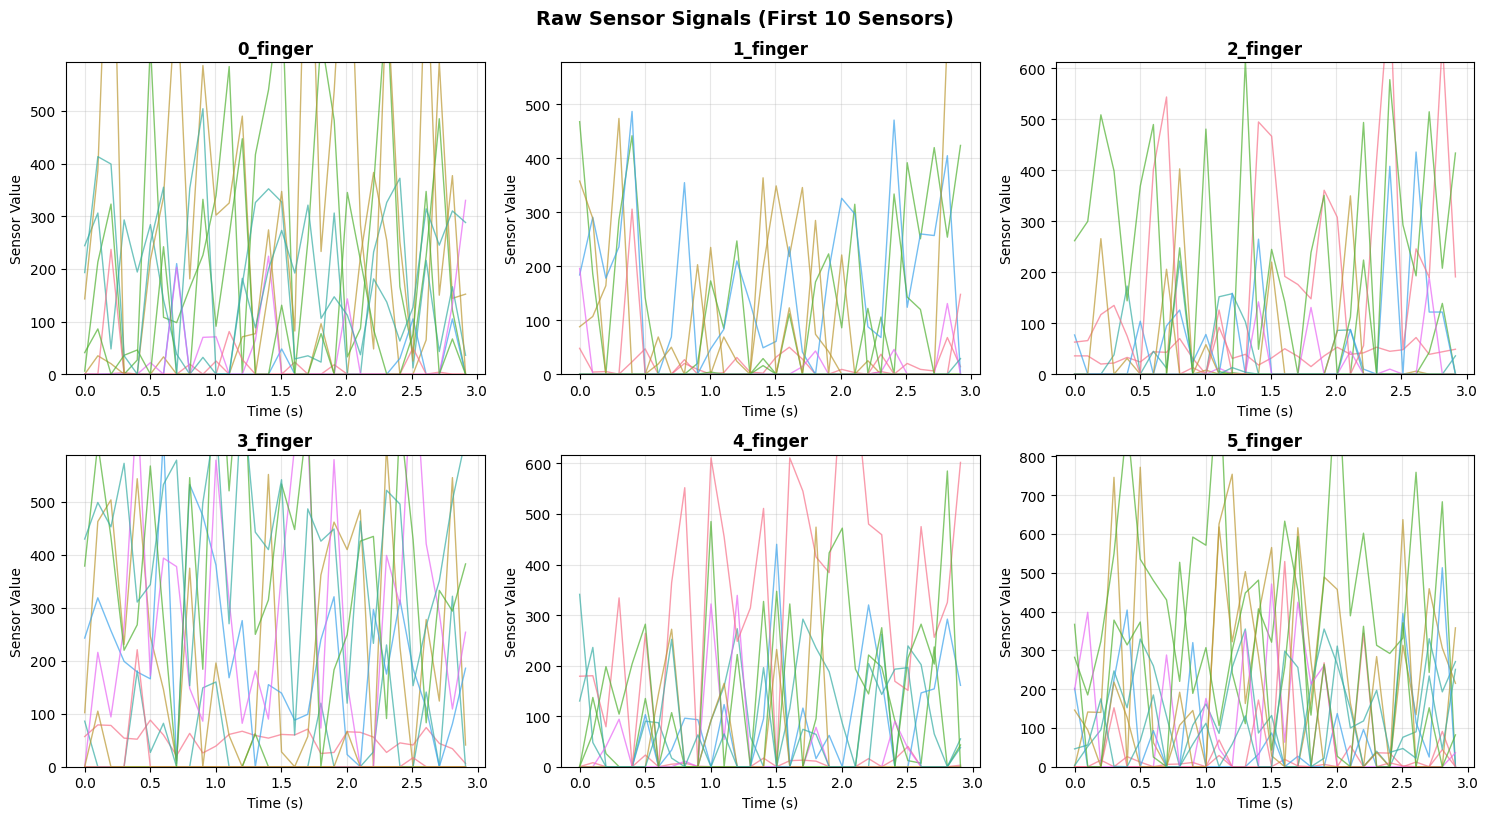

In [17]:
# 1. Plot raw signals for a few sensors and gestures
print(" PLOTTING RAW SIGNALS...")

# Select one RANDOM sample from each gesture type
import random
gesture_samples = {}
for f in sample_files:
    gesture = Path(f).parent.name
    if gesture not in gesture_samples:
        gesture_samples[gesture] = f
        # Get all files for this gesture and pick one randomly
        # gesture_files = [file for file in sample_files if Path(file).parent.name == gesture]
        # gesture_samples[gesture] = random.choice(gesture_files)

print(f"Selected random samples: {len(gesture_samples)} gestures")

# Plot temporal signals for first 10 sensors across different gestures
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (gesture, file_path) in enumerate(gesture_samples.items()):
    if i >= 6:  # Only plot first 6 gestures
        break
        
    sample = load_sample(file_path)
    data = sample['data']
    timestamps = sample['timestamps']
    
    # Plot first 10 sensors
    for sensor_idx in range(min(10, data.shape[1])):
        axes[i].plot(timestamps, data[:, sensor_idx], alpha=0.7, linewidth=1)
    
    axes[i].set_title(f'{gesture}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Sensor Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, max(100, np.percentile(data, 95)))

plt.tight_layout()
plt.suptitle('Raw Sensor Signals (First 10 Sensors)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

 PLOTTING AGGREGATE SENSOR READINGS...


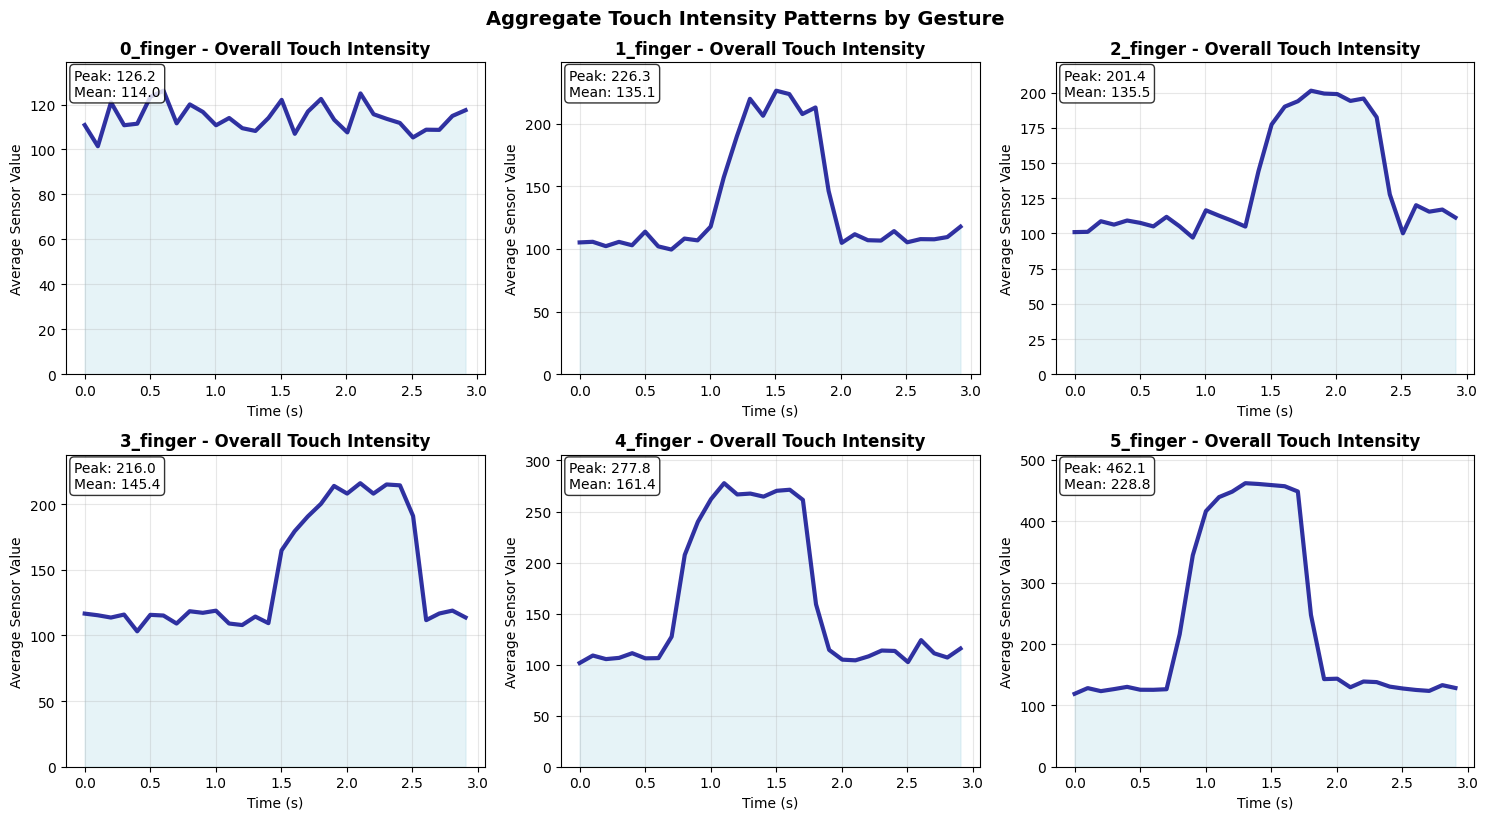

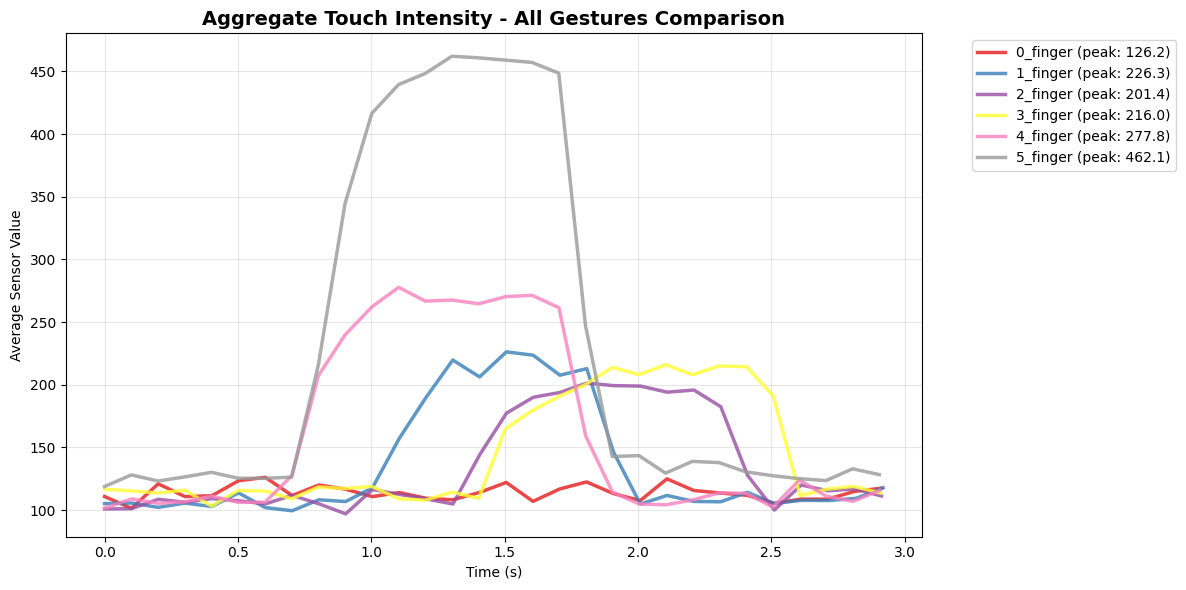

 Aggregate analysis complete! This shows overall touch intensity patterns.


In [ ]:
# Aggregate sensor readings - Overall touch intensity per gesture
print(" PLOTTING AGGREGATE SENSOR READINGS...")

# Create aggregate signals by averaging across all sensors for each sample
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (gesture, file_path) in enumerate(gesture_samples.items()):
    if i >= 6:  # Only plot first 6 gestures
        break
        
    sample = load_sample(file_path)
    data = sample['data']  # Shape: (timesteps, sensors)
    timestamps = sample['timestamps']
    
    # Calculate aggregate signal: average across all sensors at each timestep
    aggregate_signal = np.mean(data, axis=1)  # Average across sensors (axis=1 ==> columns)
    
    # Plot aggregate signal
    axes[i].plot(timestamps, aggregate_signal, linewidth=3, color='darkblue', alpha=0.8)
    axes[i].fill_between(timestamps, aggregate_signal, alpha=0.3, color='lightblue')
    
    axes[i].set_title(f'{gesture} - Overall Touch Intensity', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Average Sensor Value')
    axes[i].grid(True, alpha=0.3)
    
    # Set y-axis to show the range clearly
    y_max = max(aggregate_signal.max(), 10)  # At least 10 for scale
    axes[i].set_ylim(0, y_max * 1.1)
    
    # Add statistics text
    max_intensity = aggregate_signal.max()
    mean_intensity = aggregate_signal.mean()
    axes[i].text(0.02, 0.98, f'Peak: {max_intensity:.1f}\nMean: {mean_intensity:.1f}', 
                transform=axes[i].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Aggregate Touch Intensity Patterns by Gesture', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Compare all gestures on the same plot
plt.figure(figsize=(12, 6))
colors = plt.cm.Set1(np.linspace(0, 1, len(gesture_samples)))

for i, (gesture, file_path) in enumerate(gesture_samples.items()):
    sample = load_sample(file_path)
    data = sample['data']
    timestamps = sample['timestamps']
    
    # Calculate aggregate signal
    aggregate_signal = np.mean(data, axis=1)
    
    # Plot with different colors
    plt.plot(timestamps, aggregate_signal, linewidth=2.5, 
             label=f'{gesture} (peak: {aggregate_signal.max():.1f})', 
             color=colors[i], alpha=0.8)

plt.title('Aggregate Touch Intensity - All Gestures Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Average Sensor Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



 CREATING SPATIAL HEATMAPS...


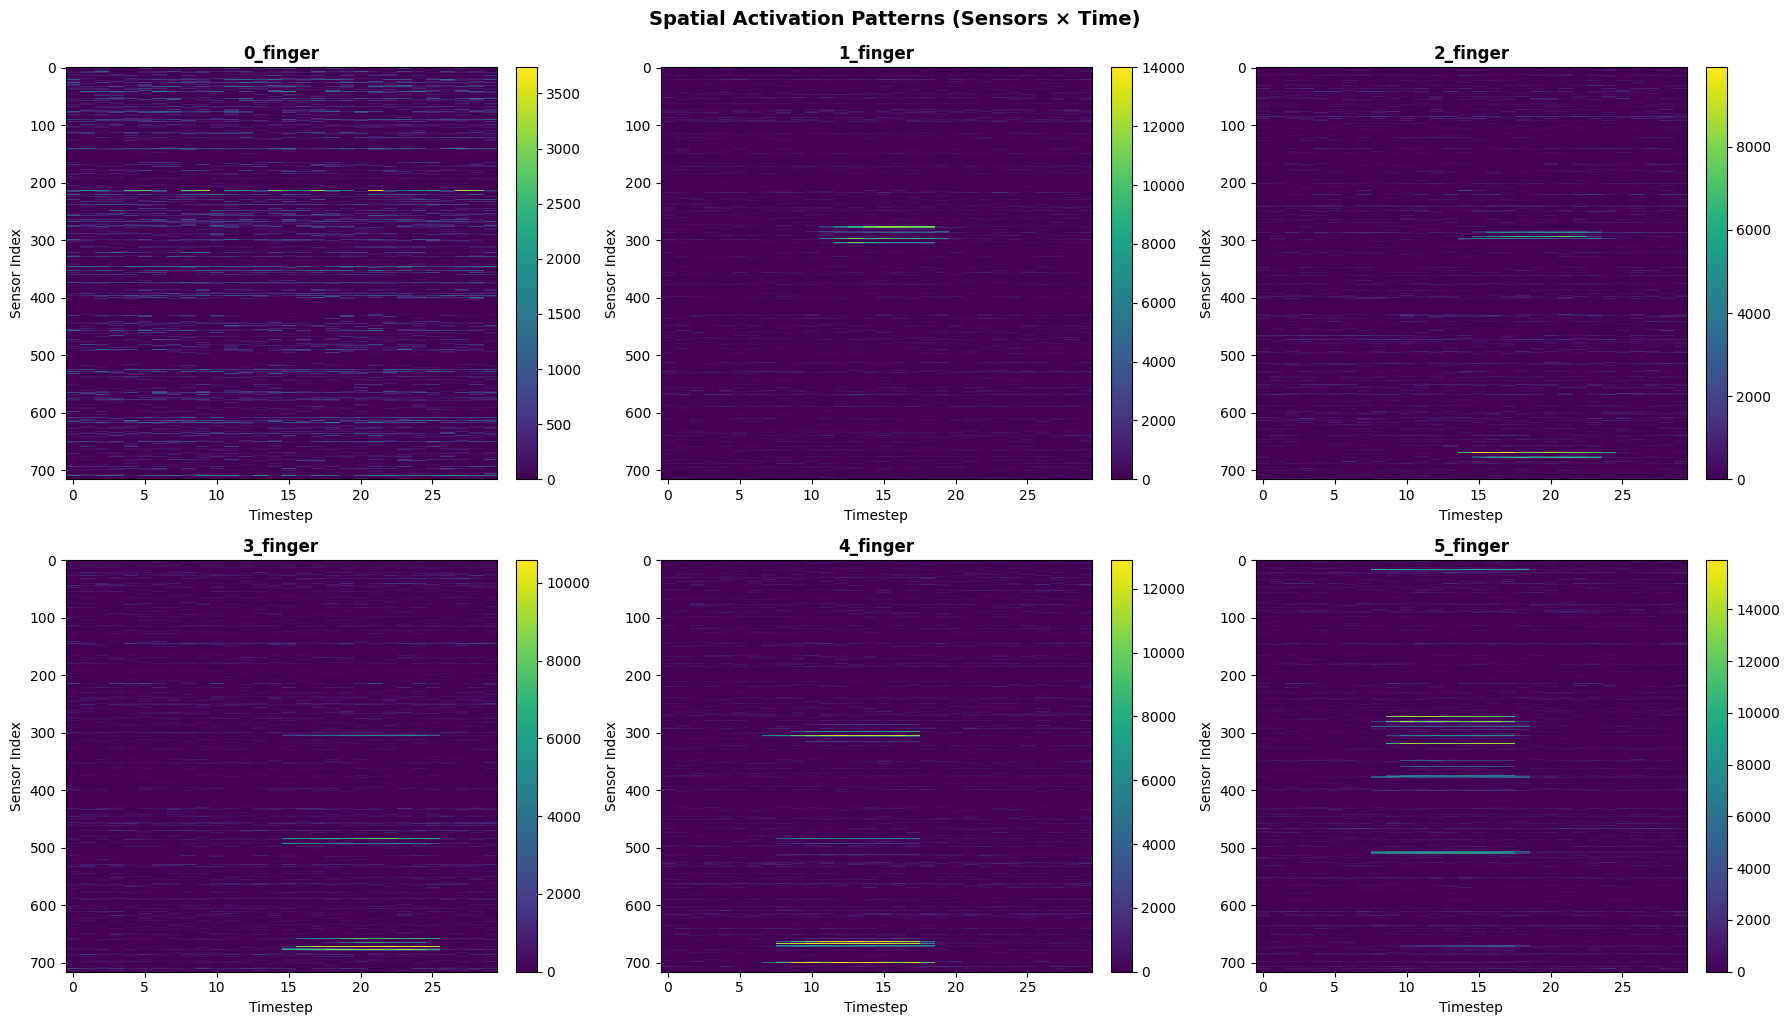

In [ ]:
# 2. Create heatmaps to see spatial activation patterns
print(" CREATING SPATIAL HEATMAPS...")

# Create heatmaps showing sensor activation over time for each gesture
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (gesture, file_path) in enumerate(gesture_samples.items()):
    if i >= 6:
        break
        
    sample = load_sample(file_path)
    data = sample['data']  # Shape: (timesteps, sensors)
    
    # Show data range for this gesture
    min_val, max_val = data.min(), data.max()
    
    # Create heatmap (sensors vs time)
    im = axes[i].imshow(data.T, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[i].set_title(f'{gesture}\n(Values: {min_val:.0f} to {max_val:.0f})', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Timestep')
    axes[i].set_ylabel('Sensor Index')
    
    # Add colorbar with better labeling
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Sensor Value\n(Pressure Level)', rotation=270, labelpad=20)

plt.tight_layout()
plt.suptitle('Spatial Activation Patterns (Sensors × Time)\nColorbar = Pressure Values', y=1.02, fontsize=14, fontweight='bold')
plt.show()



In [28]:
# 3. Compute basic stats to identify stable vs noisy sensors
print(" ANALYZING SENSOR STATISTICS...")

# Load several samples and compute sensor statistics
all_sensor_data = []
all_gestures = []

for file_path in sample_files[:20]:  # Analyze first 20 samples
    sample = load_sample(file_path)
    all_sensor_data.append(sample['data'])
    gesture = Path(file_path).parent.name
    all_gestures.append(gesture)

# Stack all data: (samples * timesteps, sensors)
combined_data = np.vstack(all_sensor_data)

# Compute per-sensor statistics
sensor_stats = pd.DataFrame({
    'sensor_id': first_sample['sensor_ids'],
    'mean': np.mean(combined_data, axis=0),
    'std': np.std(combined_data, axis=0),
    'max': np.max(combined_data, axis=0),
    'min': np.min(combined_data, axis=0),
    'range': np.max(combined_data, axis=0) - np.min(combined_data, axis=0),
    'cv': np.std(combined_data, axis=0) / (np.mean(combined_data, axis=0) + 1e-6)  # Coefficient of variation
})

print(f"\n Sensor Statistics Summary:")
print(sensor_stats.describe())

# Identify problematic sensors
high_noise_threshold = np.percentile(sensor_stats['cv'], 95)
low_activity_threshold = np.percentile(sensor_stats['range'], 10)

noisy_sensors = sensor_stats[sensor_stats['cv'] > high_noise_threshold]
inactive_sensors = sensor_stats[sensor_stats['range'] < low_activity_threshold]

print(f"\n Potentially noisy sensors (high CV): {len(noisy_sensors)} sensors")
print(f" Low-activity sensors (small range): {len(inactive_sensors)} sensors")
print(f" Good sensors: {len(sensor_stats) - len(noisy_sensors) - len(inactive_sensors)} sensors")

 ANALYZING SENSOR STATISTICS...

 Sensor Statistics Summary:
          sensor_id         mean          std          max    min  \
count    716.000000   716.000000   716.000000   716.000000  716.0   
mean   58609.118715   116.171006   111.841079   563.622905    0.0   
std     1054.209075   168.942017   109.461686   509.508934    0.0   
min    56416.000000     0.000000     0.000000     0.000000    0.0   
25%    58786.750000    16.246250    29.249493   175.000000    0.0   
50%    59025.500000    53.276667    80.130953   426.500000    0.0   
75%    59264.250000   141.234583   163.938475   829.500000    0.0   
max    59515.000000  1642.728333  1040.787265  4453.000000    0.0   

             range          cv  
count   716.000000  716.000000  
mean    563.622905    1.921723  
std     509.508934    2.117872  
min       0.000000    0.000000  
25%     175.000000    0.891349  
50%     426.500000    1.349505  
75%     829.500000    2.057330  
max    4453.000000   24.474341  

 Potentially noisy 

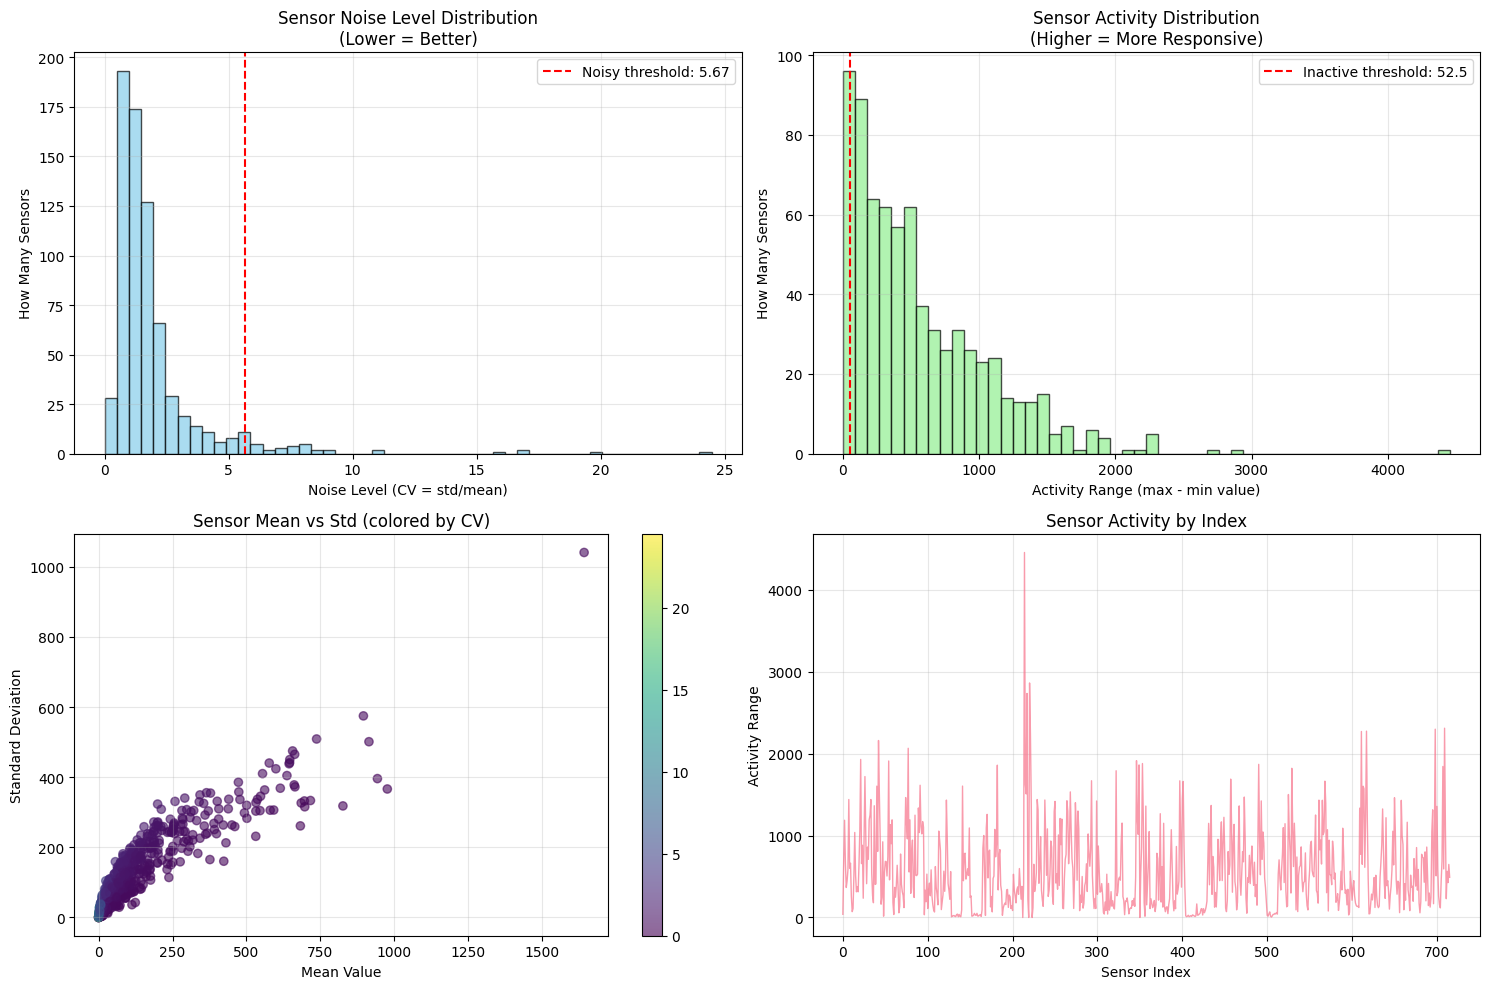

In [31]:
# Plot sensor quality metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Coefficient of variation distribution
axes[0,0].hist(sensor_stats['cv'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(high_noise_threshold, color='red', linestyle='--', label=f'Noisy threshold: {high_noise_threshold:.2f}')
axes[0,0].set_title('Sensor Noise Level Distribution\n(Lower = Better)')
axes[0,0].set_xlabel('Noise Level (CV = std/mean)')
axes[0,0].set_ylabel('How Many Sensors')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)


# 2. Sensor activity range
axes[0,1].hist(sensor_stats['range'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(low_activity_threshold, color='red', linestyle='--', label=f'Inactive threshold: {low_activity_threshold:.1f}')
axes[0,1].set_title('Sensor Activity Distribution\n(Higher = More Responsive)')
axes[0,1].set_xlabel('Activity Range (max - min value)')
axes[0,1].set_ylabel('How Many Sensors')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Mean vs Standard deviation scatter
scatter = axes[1,0].scatter(sensor_stats['mean'], sensor_stats['std'], alpha=0.6, c=sensor_stats['cv'], cmap='viridis')
axes[1,0].set_title('Sensor Mean vs Std (colored by CV)')
axes[1,0].set_xlabel('Mean Value')
axes[1,0].set_ylabel('Standard Deviation')
plt.colorbar(scatter, ax=axes[1,0])
axes[1,0].grid(True, alpha=0.3)

# 4. Sensor activity heatmap (spatial if we know positions)
# For now, just show sensor index vs activity
axes[1,1].plot(range(len(sensor_stats)), sensor_stats['range'], alpha=0.7, linewidth=1)
axes[1,1].set_title('Sensor Activity by Index')
axes[1,1].set_xlabel('Sensor Index')
axes[1,1].set_ylabel('Activity Range')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

 COMPARING GESTURE PATTERNS...


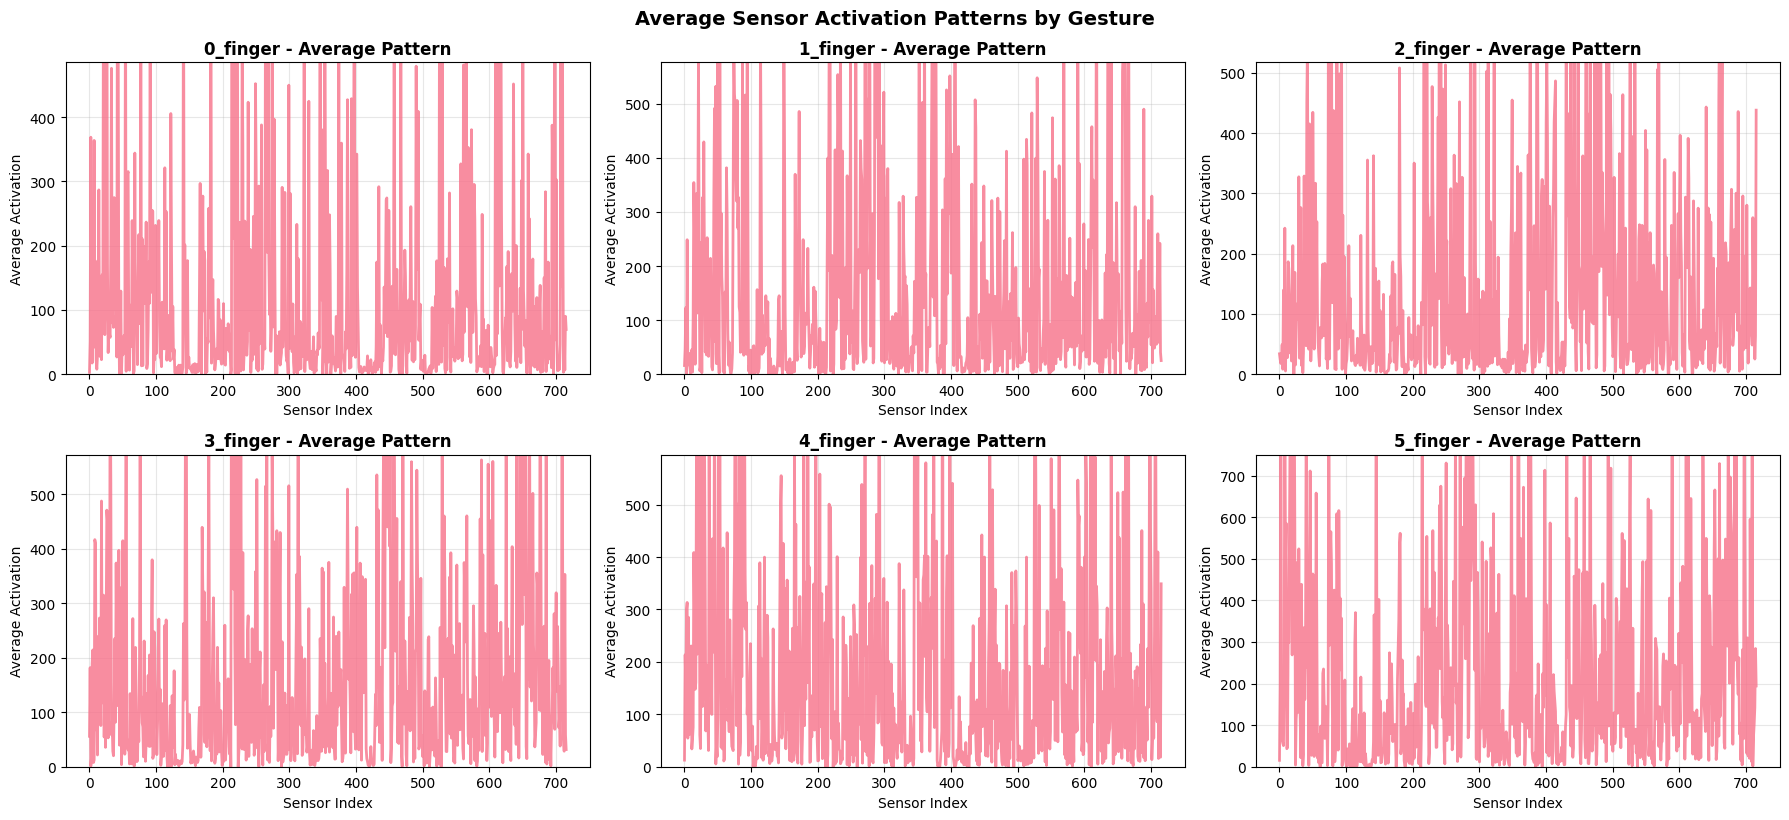

In [32]:
# 4. Compare gestures visually - Average activation patterns
print(" COMPARING GESTURE PATTERNS...")

# Compute average sensor activation for each gesture
gesture_averages = {}

for gesture in gesture_counts.keys():
    gesture_files = [f for f in sample_files if Path(f).parent.name == gesture]
    
    gesture_data = []
    for file_path in gesture_files[:15]:  # Use first 15 samples per gesture
        sample = load_sample(file_path)
        # Average over time for each sample, then collect all samples
        gesture_data.append(np.mean(sample['data'], axis=0))
    
    if gesture_data:
        gesture_averages[gesture] = np.mean(gesture_data, axis=0)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, (gesture, avg_pattern) in enumerate(gesture_averages.items()):
    if i >= 6:
        break
        
    axes[i].plot(avg_pattern, alpha=0.8, linewidth=2)
    axes[i].set_title(f'{gesture} - Average Pattern', fontweight='bold')
    axes[i].set_xlabel('Sensor Index')
    axes[i].set_ylabel('Average Activation')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, max(20, np.percentile(avg_pattern, 95)))

plt.tight_layout()
plt.suptitle('Average Sensor Activation Patterns by Gesture', y=1.02, fontsize=14, fontweight='bold')
plt.show()

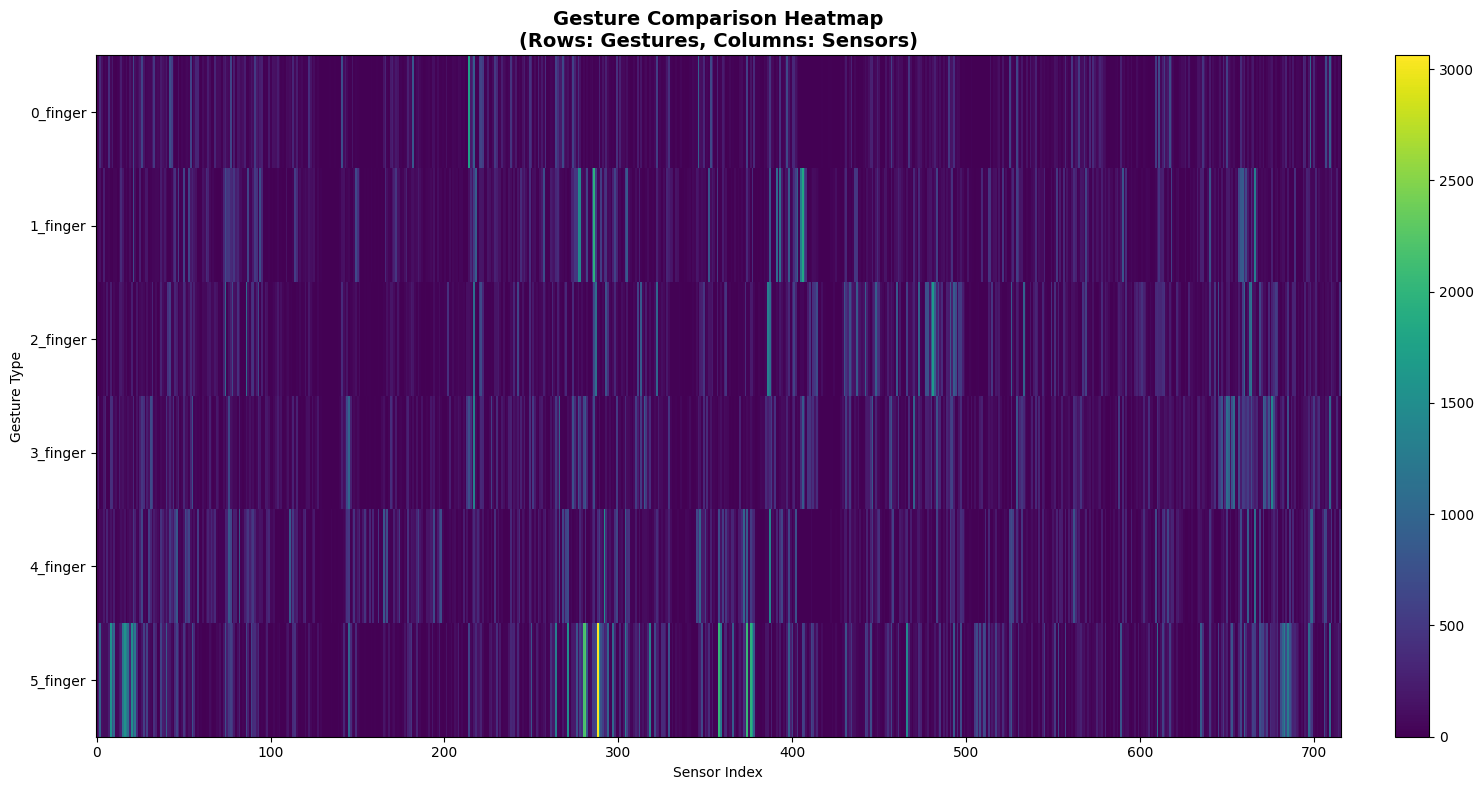

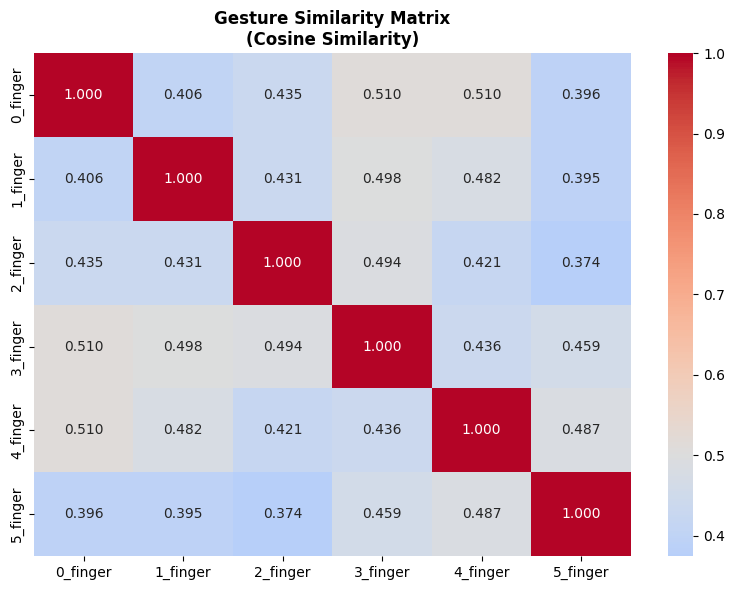

In [23]:
# Gesture comparison heatmap - all gestures side by side
if len(gesture_averages) > 1:
    # Create matrix of gesture patterns
    gesture_names = list(gesture_averages.keys())
    pattern_matrix = np.array([gesture_averages[g] for g in gesture_names])
    
    plt.figure(figsize=(15, 8))
    
    # Plot heatmap
    im = plt.imshow(pattern_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    plt.title('Gesture Comparison Heatmap\n(Rows: Gestures, Columns: Sensors)', fontsize=14, fontweight='bold')
    plt.xlabel('Sensor Index')
    plt.ylabel('Gesture Type')
    plt.yticks(range(len(gesture_names)), gesture_names)
    
    plt.tight_layout()
    plt.show()
    
    # Compute gesture similarity matrix
    from sklearn.metrics.pairwise import cosine_similarity
    
    similarity_matrix = cosine_similarity(pattern_matrix)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=gesture_names, 
                yticklabels=gesture_names, 
                annot=True, 
                cmap='coolwarm', 
                center=0.5,
                fmt='.3f')
    plt.title('Gesture Similarity Matrix\n(Cosine Similarity)', fontweight='bold')
    plt.tight_layout()
    plt.show()

In [24]:
# Summary and recommendations
print("=" * 60)
print(" DATA EXPLORATION SUMMARY & RECOMMENDATIONS")
print("=" * 60)

if sample_files:
    n_sensors = len(first_sample['sensor_ids'])
    n_samples = len(sample_files)
    n_gestures = len(gesture_counts)
    
    print(f"\n Dataset Status:")
    print(f"   • {n_sensors} sensors configured")
    print(f"   • {n_samples} total samples collected")
    print(f"   • {n_gestures} different gesture types")
    
    # Data quality assessment
    good_sensors = len(sensor_stats) - len(noisy_sensors) - len(inactive_sensors)
    quality_ratio = good_sensors / len(sensor_stats)
    
    print(f"\n Data Quality:")
    print(f"   • {good_sensors}/{n_sensors} sensors are good quality ({quality_ratio:.1%})")
    print(f"   • {len(noisy_sensors)} noisy sensors detected")
    print(f"   • {len(inactive_sensors)} low-activity sensors detected")
    
    # Recommendations
    print(f"\n Recommendations:")
    
    if quality_ratio < 0.8:
        print(f"     Consider filtering out problematic sensors for ML")
        print(f"     Check sensor calibration and baseline removal")
    else:
        print(f"    Sensor quality is good for ML analysis")
    
    if min(gesture_counts.values()) < 10:
        print(f"    Collect more samples for gestures with < 10 samples")
    else:
        print(f"    Sample count per gesture is adequate")
    
    if n_sensors == 716:
        print(f"    Using new 716-sensor curved patch")
    elif n_sensors == 216:
        print(f"     Using old 216-sensor patch data")
    elif n_sensors == 84:
        print(f"     Using very old 84-sensor patch data")
    
    print(f"\n Next Steps:")
    print(f"   1. Filter out sensors with sensor_stats['cv'] > {high_noise_threshold:.2f}")
    print(f"   2. Consider normalizing data per sensor (z-score or min-max)")
    print(f"   3. Extract features: mean, max, time-to-peak, area under curve")
    print(f"   4. Run your ML analysis on the cleaned dataset")
    
else:
    print(" No data found! Check data collection and file paths.")

print("\n" + "=" * 60)

 DATA EXPLORATION SUMMARY & RECOMMENDATIONS

 Dataset Status:
   • 716 sensors configured
   • 373 total samples collected
   • 6 different gesture types

 Data Quality:
   • 608/716 sensors are good quality (84.9%)
   • 36 noisy sensors detected
   • 72 low-activity sensors detected

 Recommendations:
    Sensor quality is good for ML analysis
    Sample count per gesture is adequate
    Using new 716-sensor curved patch

 Next Steps:
   1. Filter out sensors with sensor_stats['cv'] > 5.67
   2. Consider normalizing data per sensor (z-score or min-max)
   3. Extract features: mean, max, time-to-peak, area under curve
   4. Run your ML analysis on the cleaned dataset

